<a href="https://www.kaggle.com/code/salimhammadi07/mnist-classification-using-keras?scriptVersionId=103752040" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 1. Framing the problem

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image by computing the center of mass of the pixels, and translating the image so as to position this point at the center of the 28x28 field.  

With some classification methods (particularly template-based methods, such as SVM and K-nearest neighbors), the error rate improves when the digits are centered by bounding box rather than center of mass. If you do this kind of pre-processing, you should report it in your publications. The MNIST database was constructed from NIST's NIST originally designated SD-3 as their training set and SD-1 as their test set. However, SD-3 is much cleaner and easier to recognize than SD-1. The reason for this can be found on the fact that SD-3 was collected among Census Bureau employees, while SD-1 was collected among high-school students. Drawing sensible conclusions from learning experiments requires that the result be independent of the choice of training set and test among the complete set of samples. Therefore it was necessary to build a new database by mixing NIST's datasets.  

The MNIST training set is composed of 30,000 patterns from SD-3 and 30,000 patterns from SD-1. Our test set was composed of 5,000 patterns from SD-3 and 5,000 patterns from SD-1. The 60,000 pattern training set contained examples from approximately 250 writers. We made sure that the sets of writers of the training set and test set were disjoint. SD-1 contains 58,527 digit images written by 500 different writers. In contrast to SD-3, where blocks of data from each writer appeared in sequence, the data in SD-1 is scrambled. Writer identities for SD-1 is available and we used this information to unscramble the writers. We then split SD-1 in two: characters written by the first 250 writers went into our new training set. The remaining 250 writers were placed in our test set. Thus we had two sets with nearly 30,000 examples each. The new training set was completed with enough examples from SD-3, starting at pattern # 0, to make a full set of 60,000 training patterns. Similarly, the new test set was completed with SD-3 examples starting at pattern # 35,000 to make a full set with 60,000 test patterns. Only a subset of 10,000 test images (5,000 from SD-1 and 5,000 from SD-3) is available on this site. The full 60,000 sample training set is available.

<center> <img src="https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/02/Plot-of-a-Subset-of-Images-from-the-MNIST-Dataset.png" style="width: 600px;"> </center>

# 2. Importing dependencies

There are many deep learning frameworks, each with their own merits. In this notebook I will be working with [Tensorflow 2](https://www.tensorflow.org/tutorials/quickstart/beginner), and specifically with the [Keras API](https://keras.io/). Keras has many useful built in functions designed for the computer vision tasks. It is also a legitimate choice for deep learning in a professional setting due to its [readability](https://blog.pragmaticengineer.com/readable-code/) and efficiency, though it is not alone in this regard, and it is worth investigating a variety of frameworks when beginning a deep learning project.

One of the many helpful features that Keras provides are modules containing many helper methods for [many common datasets](https://www.tensorflow.org/api_docs/python/tf/keras/datasets), including MNIST.


In [1]:
# Loading the Keras dataset module for MNIST:
from tensorflow.keras.datasets import mnist


import matplotlib.pyplot as plt

# linear algebra
import numpy as np

# data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd 

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


With the `mnist` module, we can easily load the MNIST data, already partitioned into images and labels for both training and validation:

In [2]:
# the data, split between train and validation sets
(x_train, y_train), (x_valid, y_valid) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


# 3. Exploratory data analysis

We stated above that the MNIST dataset contained 70,000 grayscale images of handwritten digits. By executing the following cells, we can see that Keras has partitioned 60,000 of these images for training, and 10,000 for validation (after training), and also, that each image itself is a 2D array with the dimensions 28x28:

In [3]:
x_train.shape

(60000, 28, 28)

In [4]:
x_valid.shape

(10000, 28, 28)

Furthermore, we can see that these 28x28 images are represented as a collection of unsigned 8-bit integer values between 0 and 255, the values corresponding with a pixel's grayscale value where 0 is black, 255 is white, and all other values are in between:

In [5]:
x_train.dtype

dtype('uint8')

In [6]:
x_train.min()

0

In [7]:
x_train.max()

255

Using Matplotlib, we can render some of these grayscale images in our dataset:

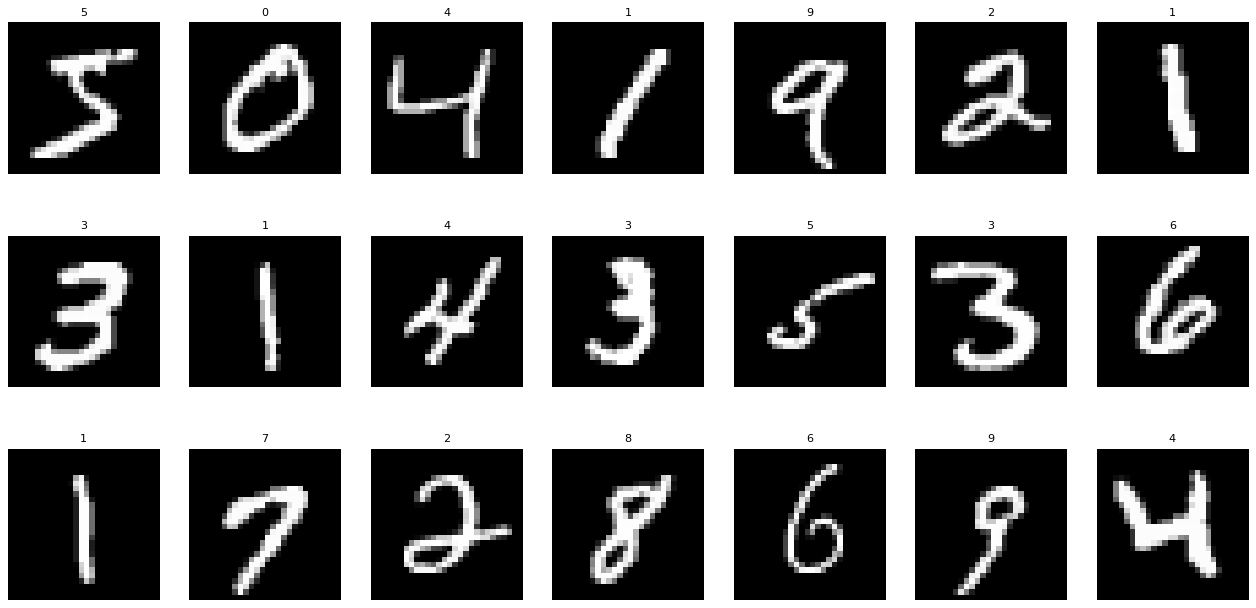

In [8]:
plt.figure(figsize=(20, 10), dpi=80)

for i in range(21):
    row = x_train[i]
    label = y_train[i]
    
    image = row.reshape(28,28)
    plt.subplot(3, 7, i+1)
    plt.title(label, fontdict={'fontsize': 10})
    plt.axis('off')
    plt.imshow(image, cmap='gray')

In this way we can now see that this is a 28x28 pixel image of a 5. Or is it a 3? The answer is in the y_train data, which contains correct labels for the data. Let's take a look:

In [9]:
y_train[0]

5

Though it's possible for a deep learning model to accept a 2-dimensional image (in our case 28x28 pixels), we're going to simplify things to start and reshape each image into a single array of 784 continuous pixels (note: 28x28 = 784). This is also called flattening the image.

In [10]:
x_train = x_train.reshape(60000, 784)
x_valid = x_valid.reshape(10000, 784)

# 4. Data pre-processing

## 4.1. Normalizing the Image Data

I'm going to normalize the data by dividing all the pixel values (whichrange between 0 and 255) by 255:

In [11]:
x_train = x_train / 255
x_valid = x_valid / 255 

## 4.2. Categorical Encoding

The labels for the images are integers between 0 and 9. Because these values represent a numerical range, the model might try to draw some conclusions about its performance based on how close to the correct numerical category it guesses.

Therefore, we will do something to our data called categorical encoding. This kind of transformation modifies the data so that each value is a collection of all possible categories, with the actual category that this particular value is set as true.

Keras provides a utility to categorically encode values, and here we use it to perform categorical encoding for both the training and validation labels:

In [12]:
y_valid[0:9]

array([7, 2, 1, 0, 4, 1, 4, 9, 5], dtype=uint8)

In [13]:
num_categories = 10

y_train = keras.utils.to_categorical(y_train, num_categories)
y_valid = keras.utils.to_categorical(y_valid, num_categories)

In [14]:
y_valid[0:9]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)

# 5. Model Building

With the data prepared for training, it is now time to create the model that we will train with the data. This first basic model will be made up of several *layers* and will be comprised of 3 main parts:

1. An input layer, which will receive data in some expected format
2. Several [hidden layers](https://developers.google.com/machine-learning/glossary#hidden-layer), each comprised of many *neurons*. Each [neuron](https://developers.google.com/machine-learning/glossary#neuron) will have the ability to affect the network's guess with its *weights*, which are values that will be updated over many iterations as the network gets feedback on its performance and learns
3. An output layer, which will depict the network's guess for a given image

## 5.1. Instantiating the Model


To begin, we will use Keras's Sequentialmodel class to instantiate an instance of a model that will have a series of layers that data will pass through in sequence:

In [15]:
model = Sequential()

2022-08-20 08:47:24.502618: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## 5.2. Input Layer

The `units` argument specifies the number of neurons in the layer. We are going to use `512` which we have chosen from experimentation. Choosing the correct number of neurons is what puts the "science" in "data science" as it is a matter of capturing the statistical complexity of the dataset. Try playing around with this value later to see how it affects training and to start developing a sense for what this number means.

We will learn more about activation functions later, but for now, we will use the `relu` activation function, which in short, will help our network to learn how to make more sophisticated guesses about data than if it were required to make guesses based on some strictly linear function.

The `input_shape` value specifies the shape of the incoming data which in our situation is a 1D array of 784 values:

In [16]:
model.add(Dense(units=512, activation='relu', input_shape=(784,)))

## 5.3. Hidden layer

Now we will add an additional densely connected layer. Again, much more will be said about these later, but for now know that these layers give the network more parameters to contribute towards its guesses, and therefore, more subtle opportunities for accurate learning:

In [17]:
model.add(Dense(units = 512, activation='relu'))

## 5.4. Output Layer

Finally, we will add an output layer. This layer uses the activation function `softmax` which will result in each of the layer's values being a probability between 0 and 1 and will result in all the outputs of the layer adding to 1. In this case, since the network is to make a guess about a single image belonging to 1 of 10 possible categories, there will be 10 outputs. Each output gives the model's guess (a probability) that the image belongs to that specific class:

In [18]:
model.add(Dense(units = 10, activation='softmax'))

## 5.5. Summarizing the Model

Keras provides the model instance method [summary](https://www.tensorflow.org/api_docs/python/tf/summary) which will print a readable summary of a model:

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


Note the number of trainable parameters. Each of these can be adjusted during training and will contribute towards the trained model's guesses.

## 5.6. Compiling the model

Again, more details are to follow, but the final step we need to do before we can actually train our model with data is to [compile](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#compile) it. Here we specify a [loss function](https://developers.google.com/machine-learning/glossary#loss) which will be used for the model to understand how well it is performing during training. We also specify that we would like to track `accuracy` while the model trains:

In [20]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

## 5.7. Training the model

Now that we have prepared training and validation data, and a model, it's time to train our model with our training data, and verify it with its validation data.

"Training a model with data" is often also called "fitting a model to data." Put this latter way, it highlights that the shape of the model changes over time to more accurately understand the data that it is being given.

When fitting (training) a model with Keras, we use the model's [fit](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) method. It expects the following arguments:

* The training data
* The labels for the training data
* The number of times it should train on the entire training dataset (called an *epoch*)
* The validation or test data, and its labels

Run the cell below to train the model. We will discuss its output after the training completes:

In [21]:
history = model.fit(
    x_train, y_train, epochs=5, verbose=1, validation_data=(x_valid, y_valid)
)

2022-08-20 08:47:26.724108: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1931 - accuracy: 0.9425 - val_loss: 0.1065 - val_accuracy: 0.9704
Epoch 2/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0991 - accuracy: 0.9746 - val_loss: 0.0930 - val_accuracy: 0.9786
Epoch 3/5
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0793 - accuracy: 0.9810 - val_loss: 0.1340 - val_accuracy: 0.9764
Epoch 4/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0704 - accuracy: 0.9842 - val_loss: 0.1295 - val_accuracy: 0.9756
Epoch 5/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0631 - accuracy: 0.9861 - val_loss: 0.1370 - val_accuracy: 0.9781


# 6. Evaluation

For each of the 5 epochs, notice the `accuracy` and `val_accuracy` scores. `accuracy` states how well the model did for the epoch on all the training data. `val_accuracy` states how well the model did on the validation data, which if you recall, was not used at all for training the model.

The model did quite well! The accuracy quickly reached close to 100%, as did the validation accuracy. We now have a model that can be used to accurately detect and classify hand-written images.

The next step would be to use this model to classify new not-yet-seen handwritten images. This is called [inference](https://blogs.nvidia.com/blog/2016/08/22/difference-deep-learning-training-inference-ai/). We'll explore the process of inference in a later exercise. 